## CO2RR 공정 datasheet 분석

----------------------------------

-------

Output 중 Required energy_total (MJ/kgCO), MSP 분석 예정

step0. 라이브러리 정리

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from kan import KAN
from kan.utils import ex_round
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


step1. 엑셀 파일 불러오기

In [2]:
# 엑셀 데이터 로드 
filepath = r"C:\Users\kepco201\Desktop\KAN_python\pykan-master\.github\workflows\TaeWoong\25.01.14_CO2RR_GSA.xlsx"
xls = pd.ExcelFile(filepath) 
df_in  = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')



step2.결측값 대체 및 이상치 제거

이상치(Outlier) 제거 / 전체 데이터의 10% 이내로 극소량만 제거

In [3]:
# 이상치(Outlier) 제거 (IQR 방식) ---

print("--- 이상치 제거 시작 ---")


print(f"이상치 제거 전 데이터 수: {len(df_in)} 개")   # len(df_in) 을 통해 이상치 제거 전 데이터 길이(개수) 출력


def remove_outliers_iqr(df_in, df_out):              # outlier 제거 함수 정의
    
    combined_df = pd.concat([df_in, df_out], axis=1) # pd.concat = 2개를 합치기 // 입력 변수(X)와 출력 변수(y)를 합쳐서 전체 데이터프레임 생성 // x랑 y를 한번에 고려
                                                     # axis = 1 --- 오른쪽으로 합치기 --- 데이터 구조를 보면 예쁘게 정리가 된다
    
    numeric_cols = combined_df.select_dtypes(include=np.number).columns  # .select_dtypes 를 통해 특정 열만 출력 outlier 를 탐지할 숫자형 컬럼만 선택
                                    # numeric_cols = 숫자로만 구성된 열들의 이름 리스트 (.colums = 그 열의 이름을 리스트로 출력)

    # 각 컬럼에 대해 이상치 경계 계산 
    Q1 = combined_df[numeric_cols].quantile(0.25)   # .quantile(0.25) = 데이터를 오름차순으로 정렬했을 떄 하위 25% 지점 
    Q3 = combined_df[numeric_cols].quantile(0.75)   # .quantile(0.75) = 데이터를 오름차순으로 정렬했을 떄 상위 25% 지점 
    IQR = Q3 - Q1 # IQR은 대략 상위 25% - 상위75% = 중간정도의 값에 해당
    
    lower_bound = Q1 - 6 * IQR  # 보통은 1.5* IQR을 진행하지만 최대한 삭제되는 데이터가 적도록 진행
    upper_bound = Q3 + 6 * IQR
    

    # 밑의 줄은 공부를 더 해보자
    # 모든 컬럼에 대해 정상 범위 내에 있는 데이터만 True로 표시
    # (row의 어떤 컬럼이라도 이상치면 해당 row 전체가 False가 됨)
    condition = ~((combined_df[numeric_cols] < lower_bound) | (combined_df[numeric_cols] > upper_bound)).any(axis=1)
    

    # 정상 범위에 있는 데이터만 필터링
    df_in_no_outliers = df_in[condition]
    df_out_no_outliers = df_out[condition]
    
    return df_in_no_outliers, df_out_no_outliers

# 3. 함수를 사용하여 이상치 제거
#    이전에 결측치를 제거한 df_in_cleaned, df_out_cleaned를 사용합니다.
df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)


# 4. 이상치 제거 후 남은 데이터 개수 확인
removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")


# 이제 'df_in_final'과 'df_out_final'을 사용하자




# 입력 변수(X) 선택
# 모델이 '총 필요 에너지'를 예측하는 데 사용할 정보(컬럼)들을 선택
X = df_in_final[[
    "Current density (mA/cm2)", 
    "Faradaic efficiency (%)", 
    "CO coversion",
    "Voltage (V)", 
    "Electricity cost ($/kWh)", 
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)", 
    "Crossover rate"
]].values

predicting = "MSP ($/kgCO)" # 다른 output 변수 보고싶으면 이거 보면 됨 # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
###### 이거를 수정해서 다른 output도 보자

y = df_out_final[predicting].values.reshape(-1, 1)   # df_out_final[] 는 pandas datatframe이기에 이것을 skitlearn 이나 Keras 형태로 바꾸기 -- 그래야 
                                                     # .values 를 통해 Numpy 배열로 변환 (값만 뽑기 때문) # 그 후에 reshape(-1.1) 을 통해 
                                                     # .reshape()을 이용해 열 1








# 1단계: 먼저 train+val과 test로 분할 (80:20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2단계: train+val을 train과 val로 분할 (64:16, 전체 대비)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)


# 최종 비율 확인
# (X[:,0])~(X[:,7]) 에 각각의 입력변수들의 값들이 각각 저장됨




print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")  
print(f"테스트셋 크기: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

from sklearn.preprocessing import MinMaxScaler
import numpy as np



# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))




X_train_norm = scaler_X.fit_transform(X_train) # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train) # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

# 3. 학습된 스케일러로 검증 및 테스트 데이터 변환 (transform)
# X_train의 기준으로 나머지 데이터들을 변환합니다.
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)   # y_val 과 y_test 도 y_train 의 정규분포를 따라 변환된다
y_test_norm = scaler_y.transform(y_test)

# 딥러닝을 진행하기 전 모든 데이터셋을 tensor로 변환  # 원래는 numpy 배열이었음 --- 아까 scikitlearn의 train test split 이나 .fit transform 스케일러를 사용하였기에 
X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32, device=device)
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train_norm, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val_norm, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32, device=device)

print(f"모든 텐서가 {device}에 배치됨")

# 나중에 정의하기 편하게 dataset을 정의하기 -- 참고로 dataset들은 tensor 이다

dataset = {'train_input': X_train_tensor,'train_label': y_train_tensor,
            'val_input': X_val_tensor, 'val_label': y_val_tensor,
            'test_input': X_test_tensor,'test_label': y_test_tensor }    # dataset dictionary에 key값과 value 값을 설정한다

# 데이터셋 검토차 크기 확인
for key, value in dataset.items():                     #.items()를 쓰면 key와 value 값을 묶어서 출력 // .items()가 없으면 오직 key만 출력
    print(f"{key}: {value.shape}")


--- 이상치 제거 시작 ---
이상치 제거 전 데이터 수: 2501 개
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)
모든 텐서가 cpu에 배치됨
train_input: torch.Size([1521, 8])
train_label: torch.Size([1521, 1])
val_input: torch.Size([381, 8])
val_label: torch.Size([381, 1])
test_input: torch.Size([476, 8])
test_label: torch.Size([476, 1])


이상치 제거 후 X, Y 정의하기

step3. 엑셀 파일 속 data 추출 및 !predict 할 데이터 이름 입력!

step4. train_set, valadation_set, test_set 만들기 (64:16:20) 우측 하단 RAW로 일단 설정해놓음 나중에 python으로 바꾸기

step5. 데이터 정규화(normalization)_전처리 과정

step6. tensor 변환

step7. dataset dictionary 만들기

step8. 1개의 KAN 모델 생성

In [4]:
# KAN 모델 생성
model = KAN(width=[8,12,1], grid=3, k=3, seed=42, device=device)   

checkpoint directory created: ./model
saving model version 0.0


In [5]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"학습가능 파라미터 수: {num_params:,}")

for name, p in model.named_parameters():
    if p.requires_grad:
        print(f"{name:40s} {p.shape} {p.numel():5d}")

학습가능 파라미터 수: 1,296
act_fun.0.coef                           torch.Size([8, 12, 6])   576
act_fun.0.scale_base                     torch.Size([8, 12])    96
act_fun.0.scale_sp                       torch.Size([8, 12])    96
act_fun.1.coef                           torch.Size([12, 1, 6])    72
act_fun.1.scale_base                     torch.Size([12, 1])    12
act_fun.1.scale_sp                       torch.Size([12, 1])    12
symbolic_fun.0.affine                    torch.Size([12, 8, 4])   384
symbolic_fun.1.affine                    torch.Size([1, 12, 4])    48


step9. KAN 학습

| train_loss: 1.75e-02 | test_loss: 1.60e-02 | reg: 2.90e+00 | : 100%|█| 50/50 [00:37<00:00,  1.34it


saving model version 0.1


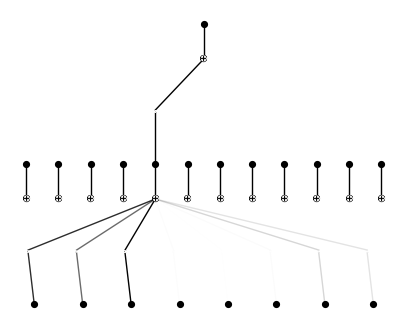

In [6]:
# KAN 학습
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)
model.plot()

basis function에 곱해지는 파라미터 ci의 리스트를 나열해보자

In [7]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)




layer 0의 전체 ci tensor 크기 
torch.Size([8, 12, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.017371850088238716, -0.03434792533516884, -0.0006643619854003191, 0.011109077371656895, 0.0430452898144722, 0.046786148101091385]


In [8]:
#pruning
model = model.prune(node_th=1e-2, edge_th=3e-2)  # 더 자르고 싶으면 값을 높이고, 덜 자르고 변수를 많이 있게 하고 싶으면 값을 낮추기

#학습
model.fit(dataset, opt="LBFGS", steps=50)  # update_grid 가 False일때랑 True일때의 차이는?


saving model version 0.2


| train_loss: 1.65e-02 | test_loss: 1.53e-02 | reg: 3.68e+00 | : 100%|█| 50/50 [00:17<00:00,  2.85it

saving model version 0.3


{'train_loss': [array(0.02796525, dtype=float32),
  array(0.02384314, dtype=float32),
  array(0.02235619, dtype=float32),
  array(0.01966984, dtype=float32),
  array(0.01892934, dtype=float32),
  array(0.01799045, dtype=float32),
  array(0.01753183, dtype=float32),
  array(0.01730647, dtype=float32),
  array(0.01708534, dtype=float32),
  array(0.01705677, dtype=float32),
  array(0.0169994, dtype=float32),
  array(0.01695539, dtype=float32),
  array(0.01693262, dtype=float32),
  array(0.01691806, dtype=float32),
  array(0.01689104, dtype=float32),
  array(0.01687537, dtype=float32),
  array(0.01680045, dtype=float32),
  array(0.01667009, dtype=float32),
  array(0.01663796, dtype=float32),
  array(0.01660389, dtype=float32),
  array(0.01658893, dtype=float32),
  array(0.01657429, dtype=float32),
  array(0.01656236, dtype=float32),
  array(0.01655776, dtype=float32),
  array(0.0165515, dtype=float32),
  array(0.01655299, dtype=float32),
  array(0.01654207, dtype=float32),
  array(0.016531

In [9]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 6])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.03355014696717262, 0.2634953558444977, 0.17430850863456726, 0.07750528305768967, -0.05326822027564049, -0.17241746187210083]


In [10]:
# refine(grid extension) 그리드 세분화(구간 세분화)(전체 구간 개수 30개로 변화) 
model = model.refine(30)
model.fit(dataset, opt="LBFGS", steps=50)

saving model version 0.4


| train_loss: 1.26e-02 | test_loss: 1.61e-02 | reg: 3.70e+00 | : 100%|█| 50/50 [00:53<00:00,  1.07s/

saving model version 0.5


{'train_loss': [array(0.01314028, dtype=float32),
  array(0.0130036, dtype=float32),
  array(0.01295591, dtype=float32),
  array(0.01292442, dtype=float32),
  array(0.01290666, dtype=float32),
  array(0.01287484, dtype=float32),
  array(0.01281704, dtype=float32),
  array(0.0127858, dtype=float32),
  array(0.01275463, dtype=float32),
  array(0.01272576, dtype=float32),
  array(0.01270467, dtype=float32),
  array(0.01268592, dtype=float32),
  array(0.0126725, dtype=float32),
  array(0.01266219, dtype=float32),
  array(0.01264949, dtype=float32),
  array(0.01263994, dtype=float32),
  array(0.01262897, dtype=float32),
  array(0.01261888, dtype=float32),
  array(0.01260756, dtype=float32),
  array(0.01259948, dtype=float32),
  array(0.01259946, dtype=float32),
  array(0.01259401, dtype=float32),
  array(0.01258911, dtype=float32),
  array(0.01258514, dtype=float32),
  array(0.01258058, dtype=float32),
  array(0.01257923, dtype=float32),
  array(0.01257564, dtype=float32),
  array(0.0125718

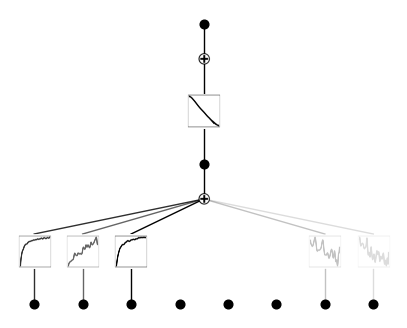

In [11]:
model.plot()

In [12]:
import torch
from kan import KAN

layer_index = 0
input_node_index = 0
output_node_index = 0



all_coeffs_layer = model.act_fun[layer_index].coef 




# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)


layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.13438177108764648, 0.2189386487007141, 0.22400696575641632, 0.2297310084104538, 0.22327224910259247, 0.22283868491649628, 0.21730920672416687, 0.21098598837852478, 0.20168472826480865, 0.1959790736436844, 0.18802092969417572, 0.17808347940444946, 0.16852664947509766, 0.1592855453491211, 0.1481494903564453, 0.13906854391098022, 0.12680409848690033, 0.11791565269231796, 0.10525943338871002, 0.09670709818601608, 0.0825277715921402, 0.07277707010507584, 0.0602496899664402, 0.05082787573337555, 0.03389018774032593, 0.024740632623434067, 0.012787885963916779, -0.004606175702065229, -0.017586294561624527, -0.028591284528374672, -0.04425017163157463, -0.05573048070073128, -0.0631411150097847]


step11. KAN symbolification

fixing (0,0,0) with exp, r2=0.9814069271087646, c=2
fixing (0,1,0) with x, r2=0.9412596225738525, c=1
fixing (0,2,0) with x, r2=0.7283377051353455, c=1
fixing (0,3,0) with 0
fixing (0,4,0) with 0
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=0.6217889189720154, c=1
fixing (0,7,0) with x, r2=0.6980667114257812, c=1
fixing (1,0,0) with x, r2=0.9917252659797668, c=1
saving model version 0.6


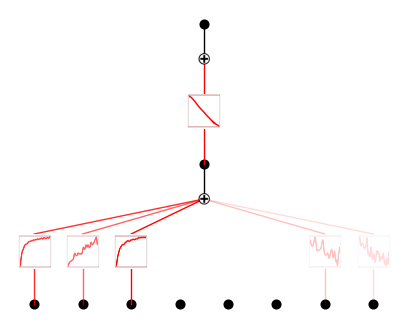

In [13]:
# 자동 모드로 심볼릭 회귀 수행
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin']   #'x^(-1)', 'x^(-2)', 'x^(-3)', 'x^(-4)'
model.auto_symbolic(lib=lib)
model.plot()

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 7.01e-02 | test_loss: 7.25e-02 | reg: 0.00e+00 | : 100%|█| 50/50 [00:17<00:00,  2.92it


saving model version 0.7


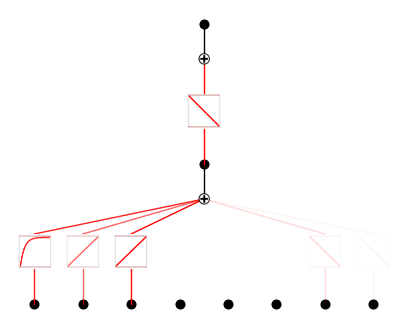

In [14]:
# symbolic 함수로 대체 후 학습
model.fit(dataset, opt="LBFGS", steps=50)
model.plot()

ci 계수들 출력하기

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 0 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.1344079077243805, 0.21893413364887238, 0.22401116788387299, 0.22973090410232544, 0.22327269613742828, 0.222832590341568, 0.21732144057750702, 0.21097813546657562, 0.20168988406658173, 0.19597475230693817, 0.1880246102809906, 0.17808127403259277, 0.1685279905796051, 0.1592855155467987, 0.14814959466457367, 0.1390693485736847, 0.1268032193183899, 0.117916539311409, 0.10525953769683838, 0.09670700132846832, 0.08252798765897751, 0.0727766677737236, 0.06025027111172676, 0.05082758888602257, 0.03389037400484085, 0.024740474298596382, 0.01278801541775465, -0.004606188274919987, -0.017586341127753258, -0.028591161593794823, -0.04425010457634926, -0.05573036149144173, -0.06314105540513992]


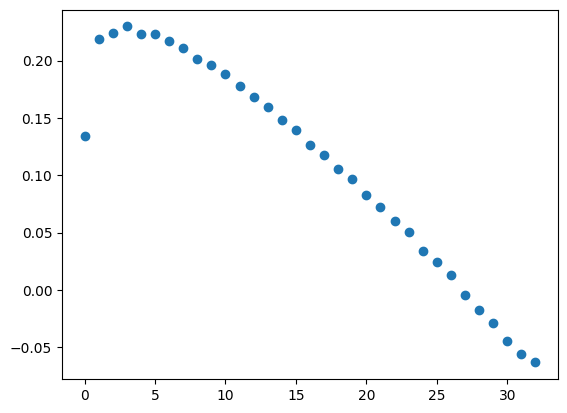

In [15]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 0
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 1 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.11490721255540848, 0.12071439623832703, 0.11823968589305878, 0.1154288500547409, 0.11156846582889557, 0.10785157233476639, 0.10299888998270035, 0.10458991676568985, 0.09801212698221207, 0.0939442589879036, 0.08903254568576813, 0.08804100006818771, 0.08144006133079529, 0.07793676853179932, 0.07131429016590118, 0.06596547365188599, 0.06689387559890747, 0.05905108526349068, 0.05354366824030876, 0.05400841683149338, 0.044740524142980576, 0.04330303519964218, 0.03575657680630684, 0.027030203491449356, 0.027907226234674454, 0.01767522282898426, 0.013188504613935947, 0.008419662714004517, 0.005104220472276211, 0.00039296830072999, -0.0030044405721127987, -0.022811822593212128, -0.0011774325976148248]


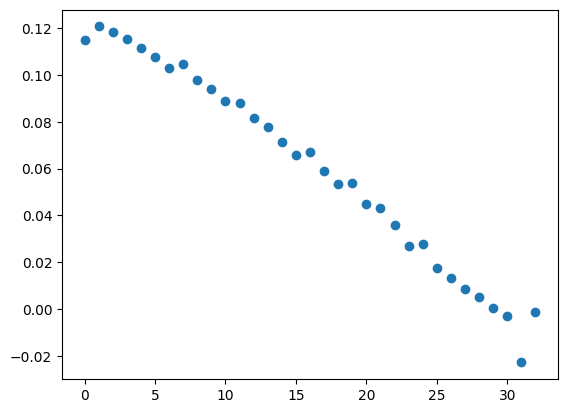

In [16]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 1
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 2 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.22397544980049133, 0.2683223485946655, 0.2889920175075531, 0.2960555851459503, 0.3017638325691223, 0.29645103216171265, 0.29327139258384705, 0.2878795564174652, 0.27446359395980835, 0.26717060804367065, 0.26323458552360535, 0.2506844997406006, 0.24579234421253204, 0.23189593851566315, 0.2141946405172348, 0.2059652954339981, 0.1964500993490219, 0.18328920006752014, 0.17347662150859833, 0.16136682033538818, 0.14435379207134247, 0.1364791840314865, 0.12101235240697861, 0.10678532719612122, 0.09775570780038834, 0.07799750566482544, 0.06433705985546112, 0.045683566480875015, 0.02999373897910118, 0.014729105867445469, -0.0012869271449744701, -0.018326472491025925, -0.029037808999419212]


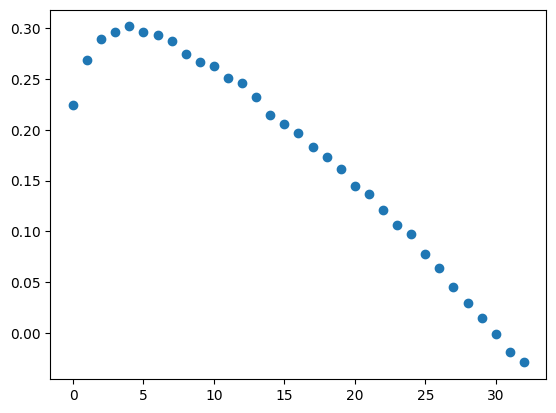

In [17]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 2
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 3 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.07409104704856873, 0.07065097987651825, 0.06740951538085938, 0.06427512317895889, 0.061008065938949585, 0.05756773427128792, 0.054084986448287964, 0.05083434283733368, 0.047685958445072174, 0.04445447772741318, 0.040936678647994995, 0.03727789595723152, 0.03348739072680473, 0.029548678547143936, 0.02544029988348484, 0.02115788497030735, 0.016763878986239433, 0.012420213781297207, 0.008166918531060219, 0.004105211701244116, -6.987232336541638e-05, -0.004144146107137203, -0.008457006886601448, -0.012711616232991219, -0.016970954835414886, -0.02133803628385067, -0.026001200079917908, -0.030924716964364052, -0.03583830967545509, -0.040771666914224625, -0.04590489715337753, -0.05117841809988022, -0.05667426809668541]


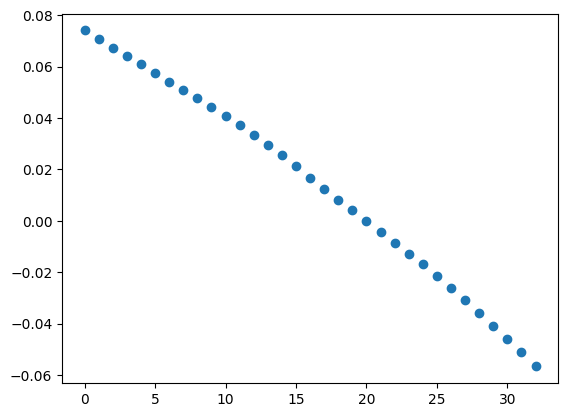

In [18]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 3
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 4 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.031865496188402176, 0.031467195600271225, 0.031068898737430573, 0.03065158985555172, 0.03024740144610405, 0.029830077663064003, 0.029428867623209953, 0.029029902070760727, 0.028635499998927116, 0.028200848028063774, 0.027747714892029762, 0.027291037142276764, 0.026836836710572243, 0.026351524516940117, 0.02583715133368969, 0.02533002197742462, 0.024796921759843826, 0.024235794320702553, 0.023642394691705704, 0.023052649572491646, 0.02245955355465412, 0.0218841340392828, 0.021323634311556816, 0.020743491128087044, 0.020151687785983086, 0.019538700580596924, 0.018957527354359627, 0.018386729061603546, 0.017829814925789833, 0.017281988635659218, 0.016763389110565186, 0.01627483405172825, 0.015808073803782463]


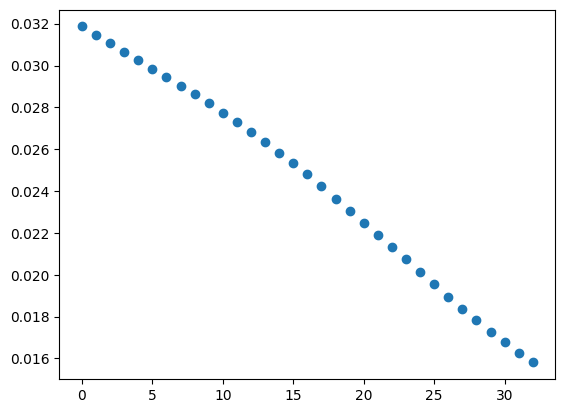

In [19]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 4
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 5 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.11300933361053467, 0.11100015789270401, 0.10871504992246628, 0.10622230917215347, 0.10354635864496231, 0.10079418867826462, 0.09798743575811386, 0.09519024938344955, 0.09230918437242508, 0.08920976519584656, 0.08607441931962967, 0.08287414908409119, 0.07970278710126877, 0.07632427662611008, 0.07308436185121536, 0.06986501067876816, 0.06659037619829178, 0.0632377564907074, 0.05992727354168892, 0.05660795792937279, 0.053260259330272675, 0.049826040863990784, 0.046448659151792526, 0.04262331873178482, 0.038343656808137894, 0.03383251279592514, 0.02933657541871071, 0.024922017008066177, 0.020572496578097343, 0.01642134226858616, 0.012120034545660019, 0.007529076188802719, 0.0024952867534011602]


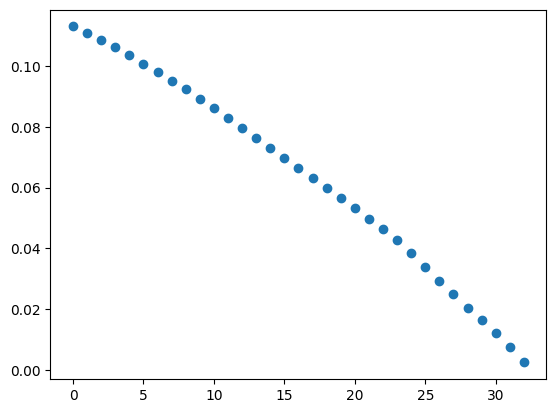

In [20]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 5
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 6 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.14733274281024933, 0.13812030851840973, 0.13572324812412262, 0.13231801986694336, 0.13029052317142487, 0.12856195867061615, 0.12693367898464203, 0.12182990461587906, 0.11677782982587814, 0.11459755152463913, 0.11109686642885208, 0.10818250477313995, 0.10515625774860382, 0.10319564491510391, 0.10150864720344543, 0.09517280757427216, 0.09040699899196625, 0.08712667971849442, 0.0832470953464508, 0.08067341148853302, 0.07457807660102844, 0.07138329744338989, 0.06863629072904587, 0.06621679663658142, 0.06039290875196457, 0.05465950816869736, 0.054598093032836914, 0.04489588364958763, 0.043489184230566025, 0.03512732684612274, 0.03714758902788162, 0.03050287626683712, 0.040019284933805466]


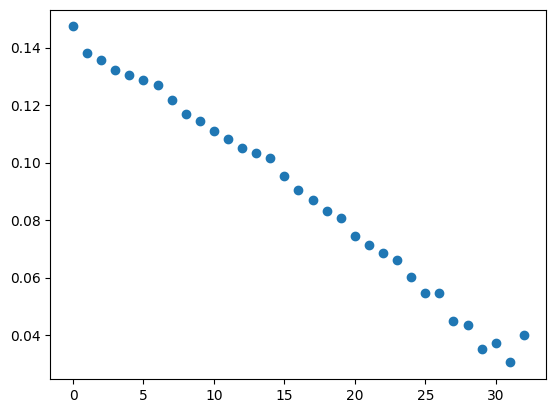

In [21]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 6
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

layer 0의 전체 ci tensor 크기 
torch.Size([8, 1, 33])
------------------------------
input node 7 -> output node 0 edge 활성화 함수 계수(ci) 
 
[0.16547812521457672, 0.17471130192279816, 0.16675055027008057, 0.16242530941963196, 0.15766091644763947, 0.15247303247451782, 0.1465654969215393, 0.14209246635437012, 0.1370513141155243, 0.13425293564796448, 0.12460828572511673, 0.12045292556285858, 0.112751305103302, 0.10986382514238358, 0.10194362699985504, 0.09547559916973114, 0.09071026742458344, 0.08229153603315353, 0.07728227972984314, 0.07235997170209885, 0.06466333568096161, 0.059901632368564606, 0.051191188395023346, 0.046541567891836166, 0.03917401283979416, 0.03236906975507736, 0.02690046839416027, 0.01717069186270237, 0.012293701991438866, 0.002719263546168804, -0.0017087574815377593, -0.014013435691595078, -0.0035380087792873383]


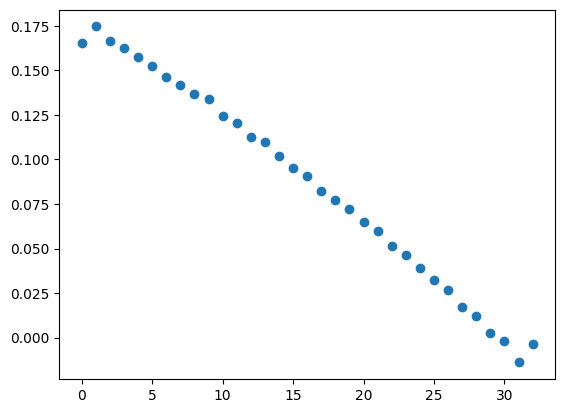

In [22]:
import torch
from kan import KAN
import matplotlib.pyplot as plt

layer_index = 0
input_node_index = 7
output_node_index = 0


all_coeffs_layer = model.act_fun[layer_index].coef 

# 특정 엣지의 활성화 함수 계수(coef) 인덱싱 
specific_act_fun_coeffs = all_coeffs_layer[input_node_index, output_node_index, :]   
# 4. 결과 출력
print(f"layer {layer_index}의 전체 ci tensor 크기 \n{all_coeffs_layer.shape}")
print("-" * 30)

print(f"input node {input_node_index} -> output node {output_node_index} edge 활성화 함수 계수(ci) \n ")

ci_list = specific_act_fun_coeffs.tolist()   # tensor 를 파이썬 리스트로 변환하여 출력
print(ci_list)

plt.scatter(list(range(len(ci_list))), ci_list)

step12. symbolic 수식 출력

In [23]:
# 심볼릭 수식 출력
formula = ex_round(model.symbolic_formula()[0][0], 4)  # ex_round(  , 4) -- 소수점 뒤에 숫자 4개? // 
print("formula =" , formula)  
print('(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)')


formula = -0.1219*x_2 - 0.4479*x_3 + 0.0267*x_7 + 0.0084*x_8 + 0.4992 + 0.5634*exp(-8.8265*x_1)
(x_1: Current density, x_2: Faradaic efficiency, ... x_8: crossover rate)


step13. KAN이 예측한 수식 정확도 검증을 위한 함수 정의

In [24]:
# validation set으로 성능을 평가하는 함수 만들기
def evaluate_model_performance(model, dataset, scaler_y, phase="validation"):    # phase = validation 아니면 test 이다
    
    
    if phase == "validation":
        input_tensor = dataset['val_input']
        label_tensor = dataset['val_label']
    elif phase == "test":
        input_tensor = dataset['test_input']
        label_tensor = dataset['test_label']
    else:
        raise ValueError("phase는 'validation' 또는 'test'만 가능합니다")
    
    # 예측 수행
    with torch.no_grad():  # 굳이 기울기 계산할 필요 X because 이거는 test 이기에 학습 X --- 시간 더 빠르게 하려고 torch.no_grad()
        pred_norm = model(input_tensor) #input_tensor 는 val_inut or test_input / pred_norm은 그에 대한 출력값
    
    # 역정규화
    pred_real = scaler_y.inverse_transform(pred_norm.cpu().detach().numpy())   # pred_real 은 0.1~0.9 사이의 입력 val_input or test_input을 받고 출력된 값은 다시 역정규화 한 실제 출력값
    label_real = scaler_y.inverse_transform(label_tensor.cpu().detach().numpy()) # label_real은 0.1~0.9 사이의 입력 val_label or test_label을 받고 출력한 값 역정규화
    # inverse_transform 함수는  numpy 를 입력으로 받기 떄문에 pytorch tensor를 cpu로 옮기고 numpy로 변환
    
    # numpy는 cpu에서만 돌아가니까 tensor를 .cpu로 옮기고 그다음 tensor의 추가정보 (numpy 정보 + 어떻게 계산되었는지 식에 대한 정보)를 detach --- 그 다음에 .numpy()를 통해 numpy로 변환
    
    # 성능 지표 계산 from 역정규화된 label_real, pred_real 값들 from val input or test input + numpy에서 계산
    rmse = np.sqrt(mean_squared_error(label_real, pred_real))  # 오차 제곱 평균의 루트
    r2 = r2_score(label_real, pred_real)  #1에 가까울수록 좋다 
    mae = np.mean(np.abs(label_real - pred_real)) # 오차 절댓값들의 평균 -- MAE
    
    print(f"{phase} SET Performance Evaluation") # phase = validation 또는 test 
    print(f"RMSE: {rmse:.4f}")     # f"{변수:포맷코드}"
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    print(f"실제값 평균: {label_real.mean():.4f}")  #label_real의 평균값(실제값)
    print(f"예측값 평균: {pred_real.mean():.4f}")   #pred_real의 평균값(KAN 모델로 예측한 값)
    
    return pred_real, label_real, {'rmse': rmse, 'r2': r2, 'mae': mae}

Step14. Validation data(검증셋)으로 성능 평가

In [25]:
# validation dataset(검증셋)으로 성능 평가 (모델 개발 과정에서)
val_pred, val_actual, val_metrics = evaluate_model_performance(model, dataset, scaler_y, "validation")

#scaler_y : step5 에서 정의한 정규화된 y 변환법
# validation --- 검증셋 이용할거라는 의미 / 나중에 
# val_pred 변수: evaluate_model_performance 함수가 반환한 첫 번째 결과물(pred_real)(모델의 예측값 배열)이 저장
# val_actual 변수: 함수가 반환한 두 번째 결과물(label_real)(실제 정답 값 배열)이 저장
# val_metrics 변수: 함수가 반환한 세 번째 결과물(RMSE, R², MAE가 담긴 딕셔너리)이 저장


validation SET Performance Evaluation
RMSE: 0.1327
R²: 0.7480
MAE: 0.0889
실제값 평균: 0.4463
예측값 평균: 0.4338


step15. KAN이 예측한 수식의 정확도 최종계산 _ using test_input, test_label

In [26]:
# 모든 모델 개발이 완료된 후 최종 한 번만 수행
print("최종 테스트셋 평가")


# 최종 테스트셋 평가(phase만 'test'로 변경하여 테스트 데이터를 사용)(이전에 정의한 evaluate_model_performance 함수를 그대로 사용)
test_pred, test_actual, test_metrics = evaluate_model_performance(
    model, dataset, scaler_y, "test"
)

# test_pred : 모델의 예측값 , test_actual : 실제 정답 값 배열 , test_metrics : (RMSE, R², MAE가 담긴 딕셔너리)

print(f"\nFinal model performance evaluation:")
print(f"Test set RMSE: {test_metrics['rmse']:.4f}")
print(f"Test set R²: {test_metrics['r2']:.4f}")
print(f"Test set MAE: {test_metrics['mae']:.4f}")


최종 테스트셋 평가
test SET Performance Evaluation
RMSE: 0.1263
R²: 0.7415
MAE: 0.0889
실제값 평균: 0.4667
예측값 평균: 0.4626

Final model performance evaluation:
Test set RMSE: 0.1263
Test set R²: 0.7415
Test set MAE: 0.0889


step16. KAN 예측값 / 실제값 그래프

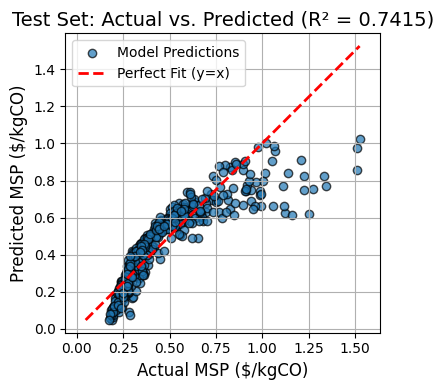

In [27]:
# step14. KAN 예측값 / 실제값 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))  # 도화지 그리기~

# test_actual (x축) vs test_pred (y축) , alpha = 투명도
plt.scatter(test_actual, test_pred, alpha=0.7, edgecolors='k', label='Model Predictions')

# 제일 작은 값, 제일 큰 값 설정
min_val = min(test_actual.min(), test_pred.min())
max_val = max(test_actual.max(), test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (y=x)')  # y = x 선긋기

# 그래프 제목과 축 레이블 설정
plt.xlabel("Actual " + predicting , fontsize=12)   # Actual 다음에 우리가 보고자 하는 output predicting 변수가 뜸
plt.ylabel("Predicted " + predicting, fontsize=12) # 
plt.title(f'Test Set: Actual vs. Predicted (R² = {test_metrics["r2"]:.4f})', fontsize=14)
plt.legend()
plt.grid(True)  # 격자 on 
plt.axis('equal') # x, y축 스케일을 동일하게 설정
plt.tight_layout()
plt.show()


잔차 플롯 (Residual Plot): 모델의 예측 오차 패턴 분석

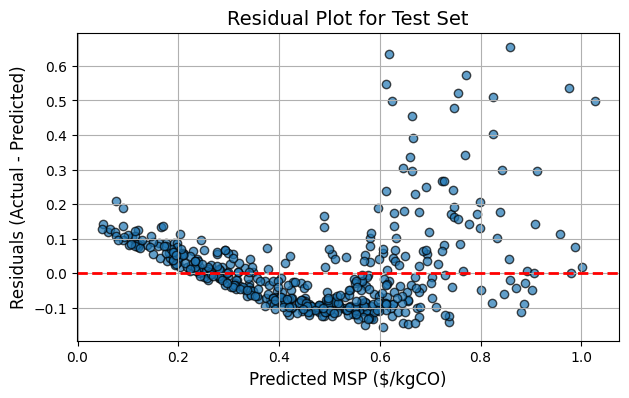

In [28]:
# 1. 잔차 계산 (실제값 - 예측값)
residuals = test_actual - test_pred

# 2. 잔차 플롯 시각화
plt.figure(figsize=(7, 4))

# x축은 예측값, y축은 잔차
plt.scatter(test_pred, residuals, alpha=0.7, edgecolors='k')

# y=0 기준선 추가 (오차가 0인 선)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)

plt.xlabel("Predicted "+predicting, fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot for Test Set', fontsize=14)
plt.grid(True)
plt.show()


2. 개별 변수 영향도 플롯 (Partial Dependence Plot): 변수-결과 관계 시각화

--- 모든 입력 변수에 대한 개별 영향도 플롯 ---


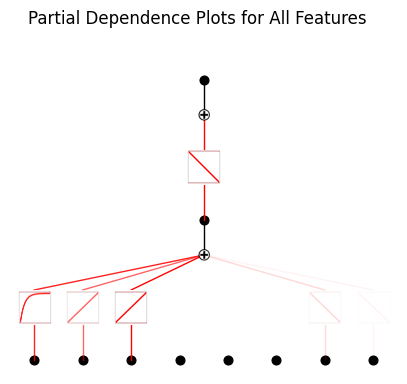

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 1. (NameError 해결) feature_names 리스트를 먼저 정의합니다.
feature_names = [
    "Current density", "Faradaic efficiency", "CO coversion", "Voltage",
    "Electricity cost", "Membrain cost", "Capture energy", "Crossover rate"
]

try:
    print("--- 모든 입력 변수에 대한 개별 영향도 플롯 ---")
    
    # 2. (TypeError 해결) 'vars' 인자 없이 plot() 함수를 호출합니다.
    # 이렇게 하면 8개 변수 각각에 대한 영향도 그래프가 한 번에 그려집니다.
    model.plot()
    
    # 전체 그래프에 대한 제목 설정 (선택 사항)
    plt.suptitle('Partial Dependence Plots for All Features', y=1.02)
    plt.show()

except Exception as e:
    print(f"오류가 발생했습니다: {e}")
    print("이전 단계에서 'model' 객체가 성공적으로 생성되었는지 확인해주세요.")



In [30]:
# step11의 코드를 다시 실행
formula = ex_round(model.symbolic_formula()[0][0], 4)
print("formula=", formula)

# 여기서 맨 왼쪽부터  x_1부터 x_8 


formula= -0.1219*x_2 - 0.4479*x_3 + 0.0267*x_7 + 0.0084*x_8 + 0.4992 + 0.5634*exp(-8.8265*x_1)


-------

------

------------------------------------------------------------------------------------------------------------------------------------------------